In [1]:
import torch
import time
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mlrg.hmc import HMCSampler
from rgflow import RGLayer, RGPartition
from itertools import chain

In [2]:
class GaussianModel(torch.nn.Module):
    ''' phi4 model energy
        E = (1/2) sum_<ij> |x_i-x_j|^2 + (r/2) sum_i |x_i|^2

        Parameters:
            r :: real - (initial) value of
            '''
    def __init__(self, r=0.):
        super().__init__()
        self.r = torch.nn.Parameter(torch.tensor(r))

    def extra_repr(self):
        return f'r={self.r.item()}'

    def return_param(self):
        return torch.exp(self.r)

    def clone(self):
        mdl = type(self)()
        mdl.load_state_dict(self.state_dict())
        return mdl

    def forward(self, x):
        energy = 0.
        for axis in range(1, x.dim()):
            dx2 = (x.roll(1,axis) - x).square().sum(1)
            energy = energy + dx2 / 2
        x2 = x.square().sum(1)
        energy = energy + torch.exp(self.r) * x2 / 2
        energy = energy.view(energy.shape[:1]+(-1,)).sum(-1)
        return energy

In [3]:
def shifted_block_circulant(tensor, dim, n):
    """get a circulant version of the tensor along the {dim} dimension.

    The additional axis is appended as the last dimension.
    E.g. tensor=[0,1,2], dim=0 --> [[0,1,2],[2,0,1],[1,2,0]]"""
    S = tensor.shape[dim]
    tmp = torch.cat([tensor.flip((dim,)), torch.narrow(tensor.flip((dim,)), dim=dim, start=0, length=S-1)], dim=dim)
    return tmp.unfold(dim, S, 2).flip((-1,)).reshape((n, n))


def create_hamiltonian(param, n):
    if n == 1:
        mat = param
    elif n == 2:
        k = (2 + param) * torch.ones(n)
        mat = torch.diag(k) + torch.diag(torch.tensor([-2]), 1) + torch.diag(torch.tensor([-2]), -1)
    elif n > 2:
        k = (2 + param) * torch.ones(n)
        mat = torch.diag(k) + torch.diag(torch.tensor([-1]).repeat(n-1), 1) + torch.diag(torch.tensor([-1]).repeat(n-1), -1)
    return mat


def create_G(param, n):
    if n == 1:
        mat = torch.zeros((2, 2))
        mat[0, 0] = 1 / param
        mat[1, 1] = 1
    elif n >= 2:
        inverse_hamil = torch.inverse(create_hamiltonian(param, n))
        mat = torch.block_diag(inverse_hamil, torch.eye(n))
    return mat


def create_inv_G(param, n):
    if n == 1:
        mat = torch.zeros((2, 2))
        mat[0, 0] = param
        mat[1, 1] = 1
    elif n >= 2:
        hamil = create_hamiltonian(param, n)
        mat = torch.block_diag(hamil, torch.eye(n))
    return mat


def create_vec(c_1, c_2, n, kernel_size_1, kernel_size_2):
    vec = torch.zeros((2, n))
    vec[0, :] = torch.cat((c_1, torch.zeros(n - kernel_size_1)))
    vec[1, :] = torch.roll(torch.cat((c_2, torch.zeros(n - kernel_size_2))), 1)
    return vec

In [4]:
class LinearMultiCNNRGLearner(torch.nn.Module):
    def __init__(self, uv_model, ir_model, n, kernel_size_1, kernel_size_2, device, base_dist='Normal'):
        super().__init__()
        self.size = n
        self.kernel_size_1 = kernel_size_1
        self.kernel_size_2 = kernel_size_2
        self.uv_model = uv_model.requires_grad_(False)
        # self.ir_model = uv_model.clone().requires_grad_(True)
        self.ir_model = ir_model.requires_grad_(True)
        self.ir_sampler = HMCSampler(self.ir_model, [1, int(n/2)])
        self.base_dist = getattr(torch.distributions, base_dist)(0., 1.)
        self.uv_param = self.uv_model.return_param()
        self.c_1 = torch.nn.Parameter(torch.randn(self.kernel_size_1, requires_grad=True)).to(device)
        self.c_2 = torch.nn.Parameter(torch.randn(self.kernel_size_2, requires_grad=True)).to(device)
        self.inv_K = create_hamiltonian(self.uv_param, n)
        self.K = torch.inverse(self.inv_K)


    def get_mat(self):
        mat = torch.inverse(shifted_block_circulant(create_vec(self.c_1, self.c_2, self.size, self.kernel_size_1, self.kernel_size_2), 1, self.size))
        return mat

    def get_ir_model(self):
        return self.ir_model

    def sample(self, samples, device):
        with torch.no_grad():
            return self.rsample(samples, device)

    def rsample(self, samples, device):
        x_ir = self.ir_sampler.sample(device, samples=samples)
        z = self.base_dist.rsample([samples, 1]).to(device)
        return x_ir, z

    def loss(self, samples, device, **kwargs):
        ir_param = self.ir_model.return_param()
        mat = torch.inverse(shifted_block_circulant(create_vec(self.c_1, self.c_2, self.size, self.kernel_size_1, self.kernel_size_2), 1, self.size))
        G = create_G(ir_param, int(self.size/2))
        x_ir = self.ir_sampler.sample(device, samples=samples, **kwargs)
        z = self.base_dist.rsample([samples, int(self.size/2)]).to(device)
        X_ir = torch.cat((x_ir, z), dim=1)
        # X_ir.requires_grad_(True)
        x_uv = torch.matmul(X_ir, torch.transpose(mat, 0, 1))
        diff = self.uv_model(x_uv) - 1/2 * torch.log(torch.det(G)) - self.ir_model(x_ir) - torch.log(torch.abs(torch.det(mat))) + 1 / 2 * torch.log(torch.det(self.K))
        Loss = diff    # original Loss
        Loss = Loss.mean()
        return Loss, self.ir_model(x_ir).mean()

    def exact_loss(self, device):
        ir_param = self.ir_model.return_param()
        mat = torch.inverse(shifted_block_circulant(create_vec(self.c_1, self.c_2, self.size, self.kernel_size_1, self.kernel_size_2), 1, self.size))
        G = create_G(ir_param, int(self.size/2))
        M = torch.matmul(mat, G)
        M = torch.matmul(self.inv_K, M)
        Loss = 1 / 2 * torch.trace(torch.matmul(torch.transpose(mat, 0, 1), M)) + 1 / 2 * torch.log(torch.det(self.K)) - 1 / 2 * torch.log(torch.det(G)) - torch.log(torch.abs(torch.det(mat)))
        return Loss

In [82]:
device = 'cpu'
n = 20
kernel_size_1 = 3
kernel_size_2 = 3
rgl = LinearMultiCNNRGLearner(GaussianModel(r=1.).to(device), GaussianModel(r=1.).to(device), n, kernel_size_1, kernel_size_2, device)
optimizer = torch.optim.Adam(rgl.parameters(), lr=0.001)
print(sum(p.numel() for p in rgl.parameters() if p.requires_grad))

7


In [87]:
for _ in range(100):
        optimizer.zero_grad()
        loss, *rest = rgl.loss(1000, device)
        # loss = rgl.exact_loss(device)
        loss.backward(retain_graph=True)
        optimizer.step()
        # scheduler.step()
        # print(f'{loss.item()}')
        print(f'{loss.item()} '+' '.join(f'{r.item()}' for r in rest))

5.234079360961914 5.008538246154785
5.1008100509643555 4.908839702606201
5.054905414581299 5.044426918029785
5.204612731933594 5.134255886077881
5.071867942810059 5.036067962646484
5.145187854766846 5.03422212600708
5.089205741882324 5.079700469970703
5.0826263427734375 4.965068340301514
5.168089389801025 4.944027423858643
5.176583290100098 4.974733829498291
5.1012444496154785 4.966634750366211
5.233312606811523 4.949219226837158
5.040383338928223 5.093923568725586
5.122564315795898 5.059993743896484
5.0288896560668945 4.952162742614746
5.0432868003845215 5.05673885345459
5.165234565734863 5.04822301864624
5.1058220863342285 4.965482711791992
5.056549549102783 4.9744157791137695
5.0918121337890625 4.97136926651001
5.107412815093994 4.965648651123047
5.177401065826416 4.988420009613037
5.227179527282715 5.080270290374756
5.012157440185547 5.107295989990234
5.179418087005615 5.193412780761719
5.10124397277832 4.959968090057373
5.067580223083496 4.900802135467529
5.083800792694092 4.97623

In [88]:
mat = rgl.get_mat()
inv_k = create_hamiltonian(torch.exp(torch.tensor(1.)), n)
M = torch.matmul(inv_k, mat)
M = torch.matmul(torch.transpose(mat, 0, 1), M).detach().numpy()
ir_param = rgl.get_ir_model().return_param().detach().numpy()
inv_G = create_inv_G(ir_param, int(n/2))

Text(0.5, 1.0, '$G^{-1}$')

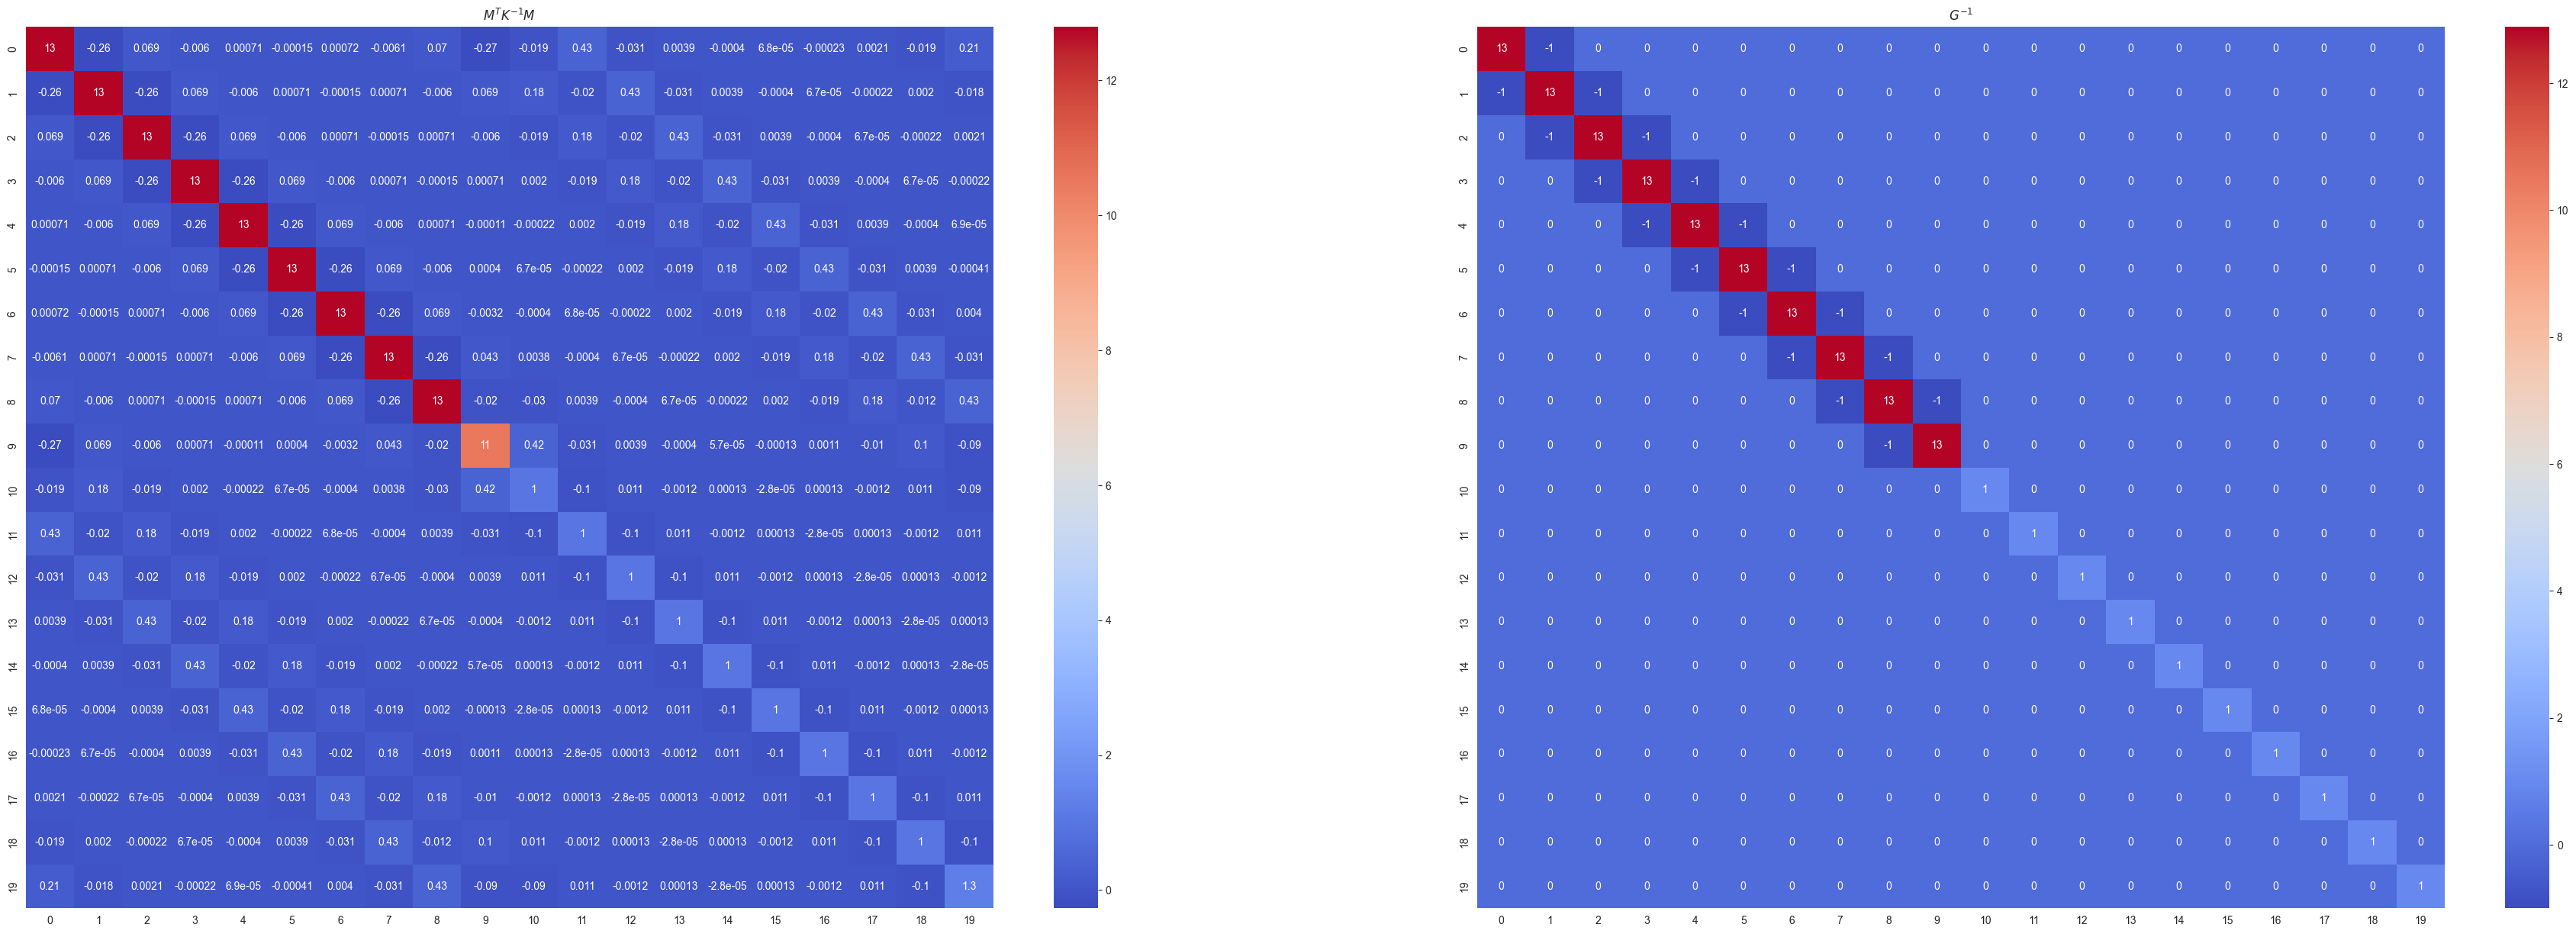

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(45, 15))
sns.heatmap(M, ax=axes[0], cmap='coolwarm',annot=True)
axes[0].set_title('$M^T K^{-1} M$')
sns.heatmap(inv_G, ax=axes[1], cmap='coolwarm',annot=True)
axes[1].set_title('$G^{-1}$')